# XGBoost

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from pathlib import Path

# --- Paths ---
# Définition du chemin principal vers les données (à adapter selon votre environnement)
#data_dir_dam = Path("C:/Users/Archi/Documents/Ponts/Cours/S2/Datbi/DATBI2025-CANCER/DataSets") # replace with your own path
data_dir_dam = Path("C:/Users/flobm/PRAMA_2025")
# Chemin vers les fichiers de features extraits par MoCo (Self-Supervised Learning)
features_dir = data_dir_dam / "train_input/train_input/moco_features"
# Chemin vers le fichier contenant les labels (ground truth)
labels_path = data_dir_dam / "train_output.csv"

# --- Load labels ---
# Chargement du fichier CSV contenant les labels associés aux échantillons
labels_df = pd.read_csv(labels_path)

# On définit "Sample ID" comme index pour faciliter les jointures futures avec les features
labels_df.set_index("Sample ID", inplace=True)

In [6]:
# import numpy as np
# import pandas as pd
# import os
# from pathlib import Path

# # --- Paths ---
# data_dir_dam = Path("C:/Users/flobm/PRAMA_2025")          # à adapter
# features_dir = data_dir_dam / "train_input/train_input/moco_features"
# labels_path  = data_dir_dam / "train_output.csv"

# # --- Load labels ---
# labels_df = pd.read_csv(labels_path).set_index("Sample ID")

# # --- Build tile-level dataset ---
X_tiles = []          # liste de matrices (n_tiles, 2048)
y_tiles = []          # liste de vecteurs (n_tiles,)

for sample_id, target in labels_df["Target"].items():
    path = features_dir / f"{sample_id}"
    if not path.exists():
        print(f"File not found: {path}")
        continue

    mat = np.load(path)              # (n_tiles ≈ 1000, 2051)
    features = mat[:, 3:]            # (n_tiles, 2048)

    X_tiles.append(features)                             # empile les tuiles
    y_tiles.append(np.full(features.shape[0], target))   # même label répété

# --- Concatenate everything ---
X = np.vstack(X_tiles)      # shape: (total_tiles, 2048)
y = np.concatenate(y_tiles) # shape: (total_tiles,)

print(f"{X.shape[0]:,} tuiles chargées, X shape = {X.shape}, y shape = {y.shape}")


344,000 tuiles chargées, X shape = (344000, 2048), y shape = (344000,)


In [7]:
X

array([[3.22281092e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.16794497e-01, 0.00000000e+00],
       [2.01828294e-02, 0.00000000e+00, 0.00000000e+00, ...,
        9.16997194e-02, 1.06236085e-01, 9.02110187e-05],
       [3.18879411e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.03183734e-01, 0.00000000e+00],
       ...,
       [1.05979040e-01, 5.04391547e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.62115747e-02],
       [3.85654159e-02, 0.00000000e+00, 2.22455338e-01, ...,
        0.00000000e+00, 1.85494106e-02, 2.56239101e-02],
       [1.82633996e-01, 1.32968258e-02, 5.57811320e-01, ...,
        0.00000000e+00, 0.00000000e+00, 7.16278926e-02]],
      shape=(344000, 2048), dtype=float32)

In [8]:
y

array([0, 0, 0, ..., 0, 0, 0], shape=(344000,))

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)

print(f"AUC ROC : {auc:.4f}")

c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:35:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC ROC : 0.8754


AUC ROC : 0.7781


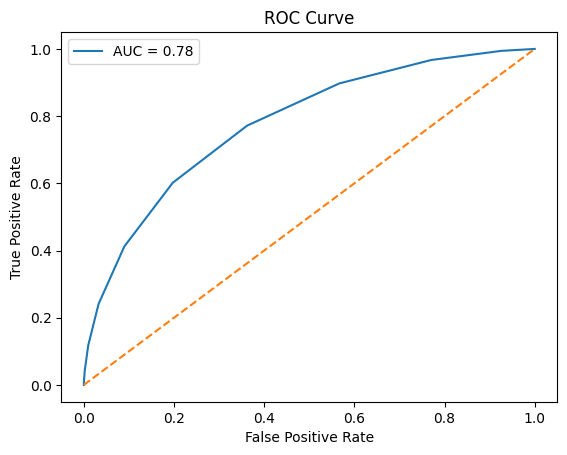

In [12]:
from sklearn.ensemble import RandomForestClassifier

model_randFor = RandomForestClassifier(n_estimators=10, random_state=42, criterion= 'log_loss')

model_randFor.fit(X_train, y_train)

y_pred_proba_rf = model_randFor.predict_proba(X_val)[:, 1]
auc_rf = roc_auc_score(y_val, y_pred_proba_rf)

print(f"AUC ROC : {auc_rf:.4f}")

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Calcul des taux de faux positifs (fpr) et vrais positifs (tpr)
# à partir des probabilités prédites
fpr, tpr, _ = roc_curve(y_val, y_pred_proba_rf)

# Tracé de la courbe ROC
plt.plot(fpr, tpr, label=f"AUC = {auc_rf:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')

# Étiquettes des axes et titre du graphique
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

# Affichage de la légende (incluant la valeur AUC)
plt.legend()
plt.show()